# Document Classification

We are working on classifying email as either spam or non-spam based on what is contained within it. Based on the documentation, 

> The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography... Our collection of spam e-mails came from our postmaster and individuals who had filed spam.  Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam.  These are useful when constructing a personalized spam filter.  One would either have to blind such non-spam indicators or get a very wide collection of non-spam to generate a general purpose spam filter.

This project will focus on utilizing NLTK to classify spam using Naive Bayes. However, we will use this benchmark against other modeling options, and compare it to using traditional logistic regression and random forest modeling.

The data can be obtained directly from the UC Irvine Machine Learning Repository website or using a package install through ``` pip install ucimlrepo ```

[Explanation](https://www.youtube.com)

## Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

from ucimlrepo import fetch_ucirepo

import warnings

In [2]:
# Ignore RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Load the Dataset

The dataset will be brought into DataFrames that will be split as

- **X**: the email's features/variables
- **y**: the email's target variable; is it spam or not spam

What we will see within the features are word frequencies within each email.

In [3]:
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.values.ravel()

In [4]:
X.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


## Split into Training and Test Sets

We will develop a two test sets. The first (dev-test) will be to see how the model responds to new data and if we determine it has a significant accuracy we will then reapply the data to new "unseen" data (test) to see how to would perform in a real world application. 

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=500, stratify=y, random_state=42) ## hold 500 emails as the final test set while holding out a temp set 
X_train, X_devtest, y_train, y_devtest = train_test_split(X_temp, y_temp, test_size=500, stratify=y_temp, random_state=42) ## we take the temp set and split 500 into a dev-test set and the remaining as our training set

## Scale Features First

We now will scale the features of the data so that it does not become influnced by possible difference in magnitudes like frequencies and averages. 

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_devtest_scaled = scaler.transform(X_devtest)
X_test_scaled = scaler.transform(X_test)

## Feature Selection (Top 15)

We will use feature selection to find the top 15 best features so that we may reduce the overhead of throwing the entire kitchen sink at our problem. The method being used is called *mutual information*, a concept that quantifies the amount of influence a feature has on a variable. The biggest difference compared to correlation is that it can detect non-linear relationships. 

We now find that some of the top features include word frequencies of the words

- all
- our
- remove
- free
- you
- money
- !

In [7]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_devtest_sel = selector.transform(X_devtest_scaled)
X_test_sel = selector.transform(X_test_scaled)

top_features = X.columns[selector.get_support()].tolist()

In [8]:
top_features

['word_freq_our',
 'word_freq_remove',
 'word_freq_free',
 'word_freq_you',
 'word_freq_your',
 'word_freq_000',
 'word_freq_money',
 'word_freq_hp',
 'word_freq_hpl',
 'word_freq_george',
 'char_freq_!',
 'char_freq_$',
 'capital_run_length_average',
 'capital_run_length_longest',
 'capital_run_length_total']

## Naive Bayes using NLTK

Naive Bayes uses the conditional probability to determine if the feature (word) influences the outcome of the email being a spam email. What is important to note is that it assumes each word is independent of each other. 

In [9]:
def to_nltk_format(X_df):
    return [dict(zip(X_df.columns, row)) for row in X_df.values]

X_train_nltk = pd.DataFrame(X_train_scaled, columns=X.columns)[top_features].iloc[:len(y_train)]
X_devtest_nltk = pd.DataFrame(X_devtest_scaled, columns=X.columns)[top_features].iloc[:len(y_devtest)]
X_test_nltk = pd.DataFrame(X_test_scaled, columns=X.columns)[top_features].iloc[:len(y_test)]

train_set = list(zip(to_nltk_format(X_train_nltk), y_train))
devtest_set = list(zip(to_nltk_format(X_devtest_nltk), y_devtest))
test_set = list(zip(to_nltk_format(X_test_nltk), y_test))

nltk_nb = NaiveBayesClassifier.train(train_set)

### Dev-Test Evaluation
After creating our model with the training set we find that our dev-test predictions have an accuracy of 0.894. This is quite good and leads us to move forward with the test set

In [10]:
nb_dev_acc = nltk_accuracy(nltk_nb, devtest_set)
print("Dev-Test Accuracy:", nb_dev_acc)

Dev-Test Accuracy: 0.908


### Test Set

The test set now runs once again using our Naive Bayes NLTK method and we get an accuracy of 0.886. There was some loss in accuracy but negligible enough not to warrant a good outcome of our model.

In [11]:
# Final Test Evaluation
nb_test_acc = nltk_accuracy(nltk_nb, test_set)
print("Test Accuracy:", nb_test_acc)

Test Accuracy: 0.876


### Classification Report

Our classification report gives us a better idea how we performed on the test set. We see that the precision of detecting spam email is high at 0.93, and we also are detecting non-spam well enough at 0.87. Anything less than 15% of the time seems like a good threshold to prevent actual emails not going through

In [12]:
pred_nb_test = [nltk_nb.classify(fs) for fs, _ in test_set]
print(classification_report(y_test, pred_nb_test))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       303
           1       0.92      0.75      0.83       197

    accuracy                           0.88       500
   macro avg       0.89      0.85      0.86       500
weighted avg       0.88      0.88      0.87       500



### Most Informative Features

The most important features in this model comes to how often, in order, does the words

- free
- money

while **capital_run_length_longest** and **capital_run_length_average** show how important the style of the email is. 

In [13]:
nltk_nb.show_most_informative_features(5)

Most Informative Features
          word_freq_free = np.float64(0.07728720405674107)      1 : 0      =     28.4 : 1.0
capital_run_length_longest = np.float64(0.045685563571529995)      1 : 0      =     27.4 : 1.0
         word_freq_money = np.float64(-0.039556737811728)      1 : 0      =     22.7 : 1.0
capital_run_length_total = np.float64(-0.4652811016969021)      0 : 1      =     22.3 : 1.0
capital_run_length_average = np.float64(-0.12480292485187236)      0 : 1      =     19.3 : 1.0


## Logistic Regression

We now run a logistic regression model to determine if an email is spam. The idea uses probability to see if the bound either reach true or false, which is perfect for us as we are trying to determine spam or not spam

In [14]:
lr = LogisticRegression(max_iter=1000, solver="lbfgs")
lr.fit(X_train_sel, y_train)

LogisticRegression(max_iter=1000)

### Dev-Test Evaluation
After creating our model with the training set we find that our dev-test predictions have an accuracy of 0.90. This is quite good and leads us to move forward with the test set

In [15]:
pred_lr_dev = lr.predict(X_devtest_sel)
print("Dev-Test Accuracy:", accuracy_score(y_devtest, pred_lr_dev))

Dev-Test Accuracy: 0.898


### Test Set

Again, the test set now runs once again using our logistic regression method and we get an accuracy of 0.904. It actually performs marginally better than what we saw in our dev-test set.

In [16]:
pred_lr_test = lr.predict(X_test_sel)
print("Test Accuracy:", accuracy_score(y_test, pred_lr_test))

Test Accuracy: 0.904


### Classification Report

The classification report again shows that the precision of detecting spam email is high at 0.91, and we also are detecting non-spam equally enough at 0.90. This time, we actually find that this model is slightly more balanced at detecting spam emails compared to NLTK and helps reduce blocking real emails

In [17]:
print(classification_report(y_test, pred_lr_test))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       303
           1       0.91      0.84      0.87       197

    accuracy                           0.90       500
   macro avg       0.90      0.89      0.90       500
weighted avg       0.90      0.90      0.90       500



## Random Forest

The last model being used is random forest. The idea behind it is building numerous decision trees and finding the best ensemble to predict our outcomes. Unlike decision trees its tree like structure is complex to plot and better used to determine its best features based on importance. 

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train)

RandomForestClassifier(random_state=42)

### Dev-Test Evaluation
After creating our model with the training set we find that our dev-test predictions have an accuracy of 0.954. This is the highest out of all the models. 

In [19]:
pred_rf_dev = rf.predict(X_devtest_sel)
print("Dev-Test Accuracy:", accuracy_score(y_devtest, pred_rf_dev))

Dev-Test Accuracy: 0.958


### Test Set

Again, the test set now runs once again using our logistic regression method and we get an accuracy of 0.938. It loses some accuracy but not enough where our other models would stand out better looking for real world results

In [20]:
pred_rf_test = rf.predict(X_test_sel)
print("Test Accuracy:", accuracy_score(y_test, pred_rf_test))

Test Accuracy: 0.936


### Classification Report

The classification report again shows that the precision of detecting spam email is high at 0.94, and we also are detecting non-spam equally enough at 0.94. This time, we actually find that this model is the best at balancing and detecting spam emails compared to NLTK and logistic regression while also reducing blocking real emails

In [21]:
print(classification_report(y_test, pred_rf_test))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       303
           1       0.95      0.88      0.92       197

    accuracy                           0.94       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.94      0.94      0.94       500



### Feature Importance
To also compare to the NLTK results we see that the importance of word features are different. We find that:

- !
- $
- remove
- your

are more important. However, some overlap such as:

- free
- money do appear in the top features.

In [22]:
importances = pd.Series(rf.feature_importances_, index=top_features)
print("\n[Random Forest] Top features by importance:")
print(importances.sort_values(ascending=False))


[Random Forest] Top features by importance:
char_freq_!                   0.165267
char_freq_$                   0.124132
word_freq_remove              0.099514
word_freq_free                0.087524
capital_run_length_average    0.079725
word_freq_your                0.076827
capital_run_length_longest    0.068923
capital_run_length_total      0.060697
word_freq_hp                  0.051192
word_freq_money               0.047736
word_freq_you                 0.038316
word_freq_our                 0.035155
word_freq_000                 0.024417
word_freq_george              0.020991
word_freq_hpl                 0.019585
dtype: float64


## Conclusion

Let's compare the final results of all our models together. We can see that the random forest model detects spam emails the best, while logistic regression and NLTK falls second and third. If a model were to be picked it would be random forest given its accuracies but if we wanted to work more on the natural language processing (NLP) more about the structures of the emails, etc, NLTK would suffice as a detection option. 

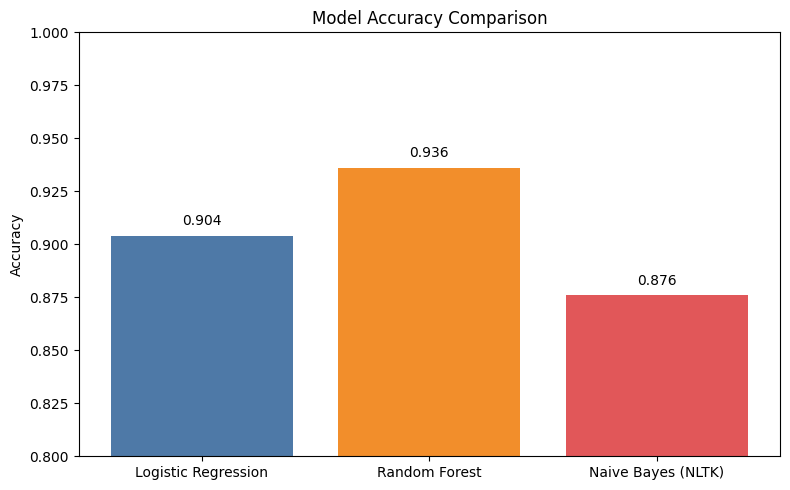

In [24]:
accuracies = {
    "Logistic Regression": accuracy_score(y_test, pred_lr_test),
    "Random Forest": accuracy_score(y_test, pred_rf_test),
    "Naive Bayes (NLTK)": nb_test_acc,
}

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['#4E79A7', '#F28E2B', '#E15759'])
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison")

for i, (name, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()